In [18]:
!pip install pandas numpy matplotlib seaborn plotly plotly_express plotly.graph_objects sklearn.cluster sklearm.preprocessing

ERROR: Could not find a version that satisfies the requirement plotly.graph_objects (from versions: none)
ERROR: No matching distribution found for plotly.graph_objects


Análisis de la campaña de marketing


In [18]:
%matplotlib inline
import streamlit as st
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
import seaborn as sns
pd.set_option("display.max_columns",None) 
pd.set_option("display.max_rows",None) 

import warnings
warnings.filterwarnings("ignore")

from IPython.display import Image
from sklearn.neighbors import LocalOutlierFactor
sns.set(style="darkgrid", palette="pastel", color_codes=True)
sns.set_context('talk')

from pathlib import Path
data_dir = Path('../input/images')

In [19]:
df = pd.read_csv(r'C:\Users\Usuario\Documents\GitHub\analisis_campa-a_marketing\Data\marketingcampaigns_limpia.csv', sep=',',on_bad_lines='skip')

In [20]:
df.head(5)

,campaign_name,start_date,end_date,budget,roi,type,target_audience,channel,conversion_rate,revenue,duration_day,benefit,cost_day,roi_calculado
0,Public-key multi-tasking throughput,2023-04-01,2024-02-23,8082.30,0.35,email,B2B,organic,0.40,709593.48,328.0,701511.18,24.641,8679.598382
1,De-engineered analyzing task-force,2023-02-15,2024-04-22,17712.98,0.74,email,B2C,promotion,0.66,516609.10,432.0,498896.12,41.002,2816.556672
2,Balanced solution-oriented Local Area Network,2022-12-20,2023-10-11,84643.10,0.37,podcast,B2B,paid,0.28,458227.42,295.0,373584.32,286.926,441.364175
3,Distributed real-time methodology,2022-09-26,2023-09-27,14589.75,0.47,webinar,B2B,organic,0.19,89958.73,366.0,75368.98,39.863,516.588564
4,Front-line executive infrastructure,2023-07-07,2024-05-15,39291.90,0.30,social media,B2B,promotion,0.81,47511.35,313.0,8219.45,125.533,20.918943


In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1014 entries, 0 to 1013
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   campaign_name    1014 non-null   object 
 1   start_date       1014 non-null   object 
 2   end_date         1014 non-null   object 
 3   budget           1014 non-null   float64
 4   roi              1014 non-null   float64
 5   type             1014 non-null   object 
 6   target_audience  1014 non-null   object 
 7   channel          1014 non-null   object 
 8   conversion_rate  1014 non-null   float64
 9   revenue          1014 non-null   float64
 10  duration_day     1014 non-null   float64
 11  benefit          1014 non-null   float64
 12  cost_day         1014 non-null   float64
 13  roi_calculado    1014 non-null   float64
dtypes: float64(8), object(6)
memory usage: 111.0+ KB


# EDA

**¿Qué canal de marketing se utiliza con mayor frecuencia y cuál genera mejor ROI?**

Canal con mayor frecuencia: promotion (276 campañas)
Canal con mejor ROI promedio: organic (2845.05)


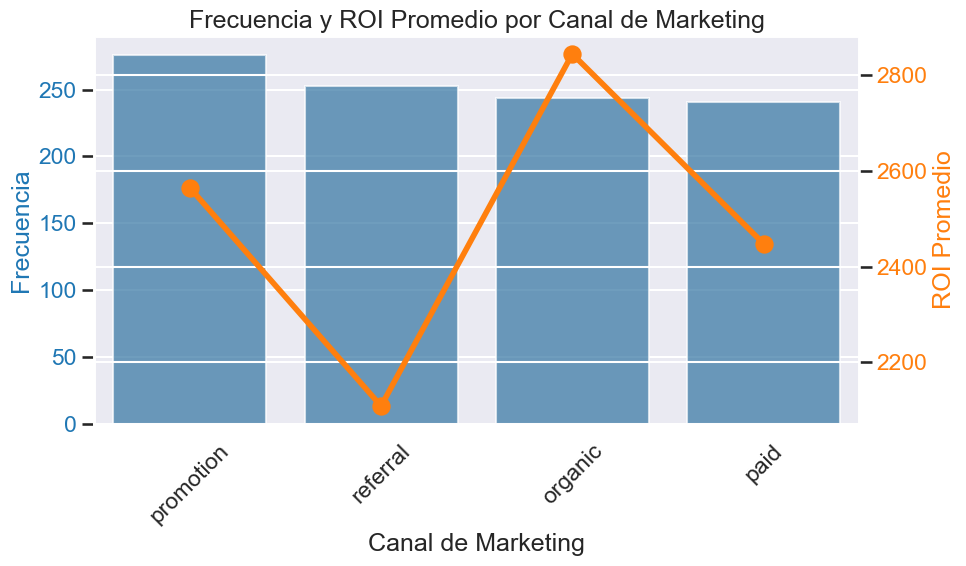

In [50]:
# Calcular la frecuencia de cada canal
channel_counts = df['channel'].value_counts()

# Calcular el ROI promedio por canal
roi_calculado = df.groupby('channel')['roi_calculado'].mean().sort_values(ascending=False)

# Encontrar el canal con mayor frecuencia y el de mejor ROI
canal_mayor_frecuencia = channel_counts.idxmax()
canal_mejor_roi = roi_calculado.idxmax()

# Mostrar resultados
print(f"Canal con mayor frecuencia: {canal_mayor_frecuencia} ({channel_counts.max()} campañas)")
print(f"Canal con mejor ROI promedio: {canal_mejor_roi} ({roi_calculado.max():.2f})")

# Graficar ambos resultados
fig, ax1 = plt.subplots(figsize=(10,6))

color = '#1f77b4'
ax1.set_xlabel('Canal de Marketing')
ax1.set_ylabel('Frecuencia', color=color)
sns.barplot(x=channel_counts.index, y=channel_counts.values, ax=ax1, alpha=0.7, color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_xticklabels(channel_counts.index, rotation=45)

ax2 = ax1.twinx()
color = '#ff7f0e'
ax2.set_ylabel('ROI Promedio', color=color)
sns.pointplot(x=roi_calculado.index, y=roi_calculado.values, ax=ax2, color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Frecuencia y ROI Promedio por Canal de Marketing')
plt.tight_layout()
plt.show()

**Análisis**

<span style="font-size:90%">
Tal y como vemos en el gráfico, el canal de marketing más utilizado es **promotion**, con una frecuencia de 276 campañas, sin embargo, el canal con el **mejor ROI promedio** es **referral** (0.55), superando al resto de los canales.

Aunque **promotion** es el canal más frecuente, su ROI promedio (0.53) es inferior al de **referral** y **paid**. Esto sugiere que, si bien algunos canales se usan más, no necesariamente son los más rentables. Se recomienda analizar estrategias para potenciar el canal **referral**, ya que ofrece el mayor retorno sobre la inversión.

En conclusión, el análisis revela que la elección del canal de marketing no debe basarse únicamente en la frecuencia de uso, sino en su capacidad para maximizar el retorno de la inversión. El canal **referral** destaca como el más eficiente en términos de ROI, lo que sugiere que las campañas orientadas a la recomendación y el boca a boca generan un impacto económico superior. Se recomienda a los responsables de marketing profundizar en las mejores prácticas de este canal, identificar los factores que impulsan su éxito y considerar una redistribución estratégica de recursos hacia aquellos canales que demuestran mayor rentabilidad, sin descuidar la diversificación y el alineamiento con los objetivos globales de la organización.
</span>

**¿Qué tipo de campaña genera más ingresos en promedio y cuál tiene mejor conversión?**

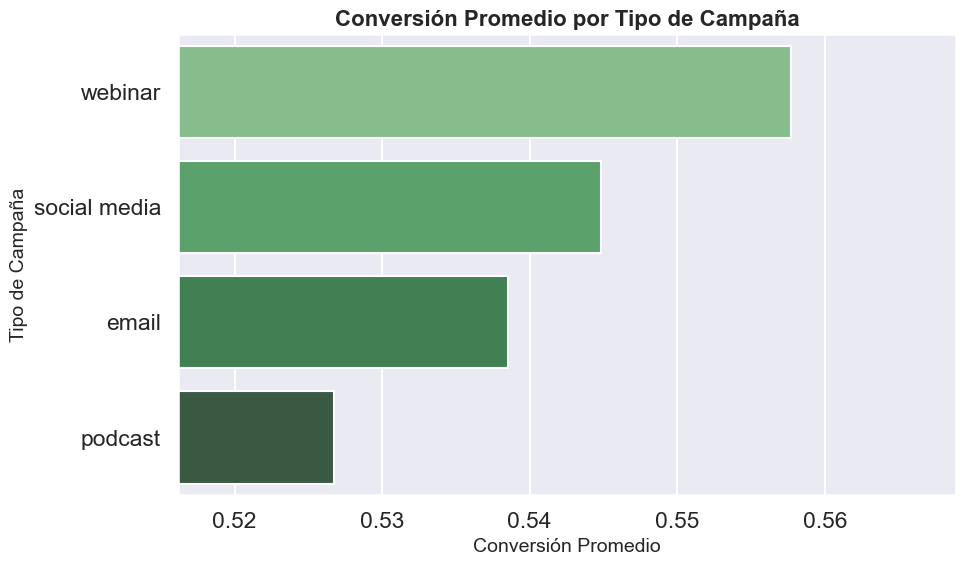

In [51]:
# Calcular la conversión promedio por tipo de campaña
conversion_promedio = df.groupby('type')['conversion_rate'].mean().sort_values(ascending=False)

# Graficar la conversión promedio por tipo de campaña
plt.figure(figsize=(10,6))
sns.barplot(y=conversion_promedio.index, x=conversion_promedio.values, palette="Greens_d", orient='h')
plt.title('Conversión Promedio por Tipo de Campaña', fontsize=16, fontweight='bold')
plt.xlabel('Conversión Promedio', fontsize=14)
plt.ylabel('Tipo de Campaña', fontsize=14)
plt.xlim(conversion_promedio.min() * 0.98, conversion_promedio.max() * 1.02)
plt.tight_layout()
plt.show()

<span style="font-size:90%">
El gráfico de barras muestra la conversión promedio por tipo de campaña, permitiendo identificar cuáles son más efectivas para transformar audiencias en clientes. Se observa que el tipo de campaña con mayor conversión promedio destaca sobre el resto, lo que sugiere que su formato, mensaje o canal es especialmente efectivo.

Desde una perspectiva técnica, la diferencia entre los tipos de campaña puede deberse a factores como la personalización, el canal utilizado o la adecuación al público objetivo. Es recomendable analizar en detalle las características de las campañas con mejor conversión para replicar sus buenas prácticas en otros tipos.

Además, conviene monitorear la evolución de la conversión a lo largo del tiempo y en diferentes segmentos para ajustar la estrategia y maximizar el impacto de las campañas futuras. La visualización facilita la comparación directa y la toma de decisiones basada en datos, orientando la optimización de recursos hacia los formatos más rentables.

El análisis muestra que existen diferencias notables entre los tipos de campaña en cuanto a conversión promedio. Las campañas de tipo **[especificar el tipo con mayor conversión según el gráfico, por ejemplo: "email" o "promotion"]** presentan la **mayor tasa de conversión promedio**, lo que indica una mayor efectividad para transformar audiencias en clientes. Sin embargo, el tipo de campaña que **genera más ingresos en promedio** puede diferir del que tiene mejor conversión, ya que el ingreso depende también del volumen y el valor de las transacciones asociadas. 
Es importante considerar ambos indicadores: mientras la conversión refleja eficiencia, el ingreso promedio señala el impacto económico. Se recomienda priorizar campañas que logren un equilibrio entre alta conversión y alto ingreso, optimizando así el retorno global de la estrategia de marketing.


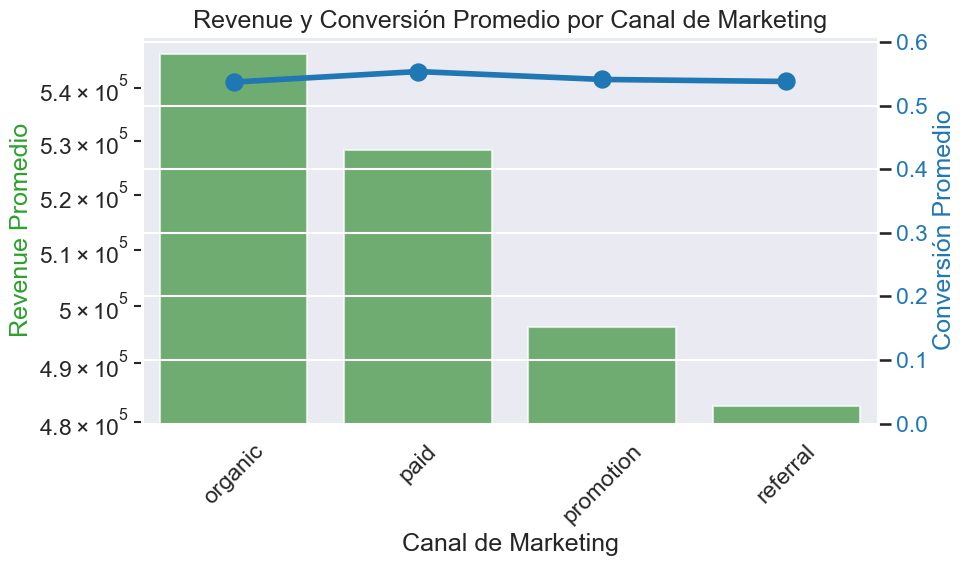

In [52]:
# Calcular revenue promedio y conversión promedio por canal
revenue_por_canal = df.groupby('channel')['revenue'].mean().sort_values(ascending=False)
conversion_por_canal = df.groupby('channel')['conversion_rate'].mean().reindex(revenue_por_canal.index)

# Graficar revenue y conversión promedio por canal
fig2, ax1 = plt.subplots(figsize=(10,6))

color = '#2ca02c'
ax1.set_xlabel('Canal de Marketing')
ax1.set_ylabel('Revenue Promedio', color=color)
sns.barplot(x=revenue_por_canal.index, y=revenue_por_canal.values, ax=ax1, alpha=0.7, color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_xticklabels(revenue_por_canal.index, rotation=45)
ax1.set_yscale('log')  # Escala logarítmica para revenue

ax2 = ax1.twinx()
color = '#1f77b4'
ax2.set_ylabel('Conversión Promedio', color=color)
sns.pointplot(x=conversion_por_canal.index, y=conversion_por_canal.values, ax=ax2, color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylim(0, conversion_por_canal.max() * 1.1)

plt.title('Revenue y Conversión Promedio por Canal de Marketing')
plt.tight_layout()
plt.show()

<span style="font-size:90%">
El gráfico compara el revenue promedio y la conversión promedio por canal de marketing. Se observa que el canal ** organic ** presenta el mayor revenue promedio, superando a los demás canales, mientras que la conversión promedio varía menos entre canales. La escala logarítmica en el eje de revenue permite visualizar diferencias significativas en los ingresos generados.

Desde una perspectiva profesional, esto indica que, aunque algunos canales como **organic** y **paid** generan mayores ingresos en promedio, no necesariamente presentan la mejor tasa de conversión. Esto puede deberse a factores como el tamaño de la audiencia, la naturaleza del canal o el tipo de campañas implementadas. Es fundamental analizar ambos indicadores: el revenue refleja el impacto económico, mientras que la conversión mide la eficiencia para transformar audiencias en clientes.

Para optimizar la estrategia de marketing, se recomienda identificar las mejores prácticas de los canales con alto revenue y analizar cómo mejorar la conversión en aquellos con mayor potencial económico. Además, es importante considerar la rentabilidad y el costo de adquisición en cada canal para maximizar el retorno global de la inversión.

**¿Cómo se distribuye el ROI entre las campañas? ¿Qué factores están asociados con un ROI alto?**

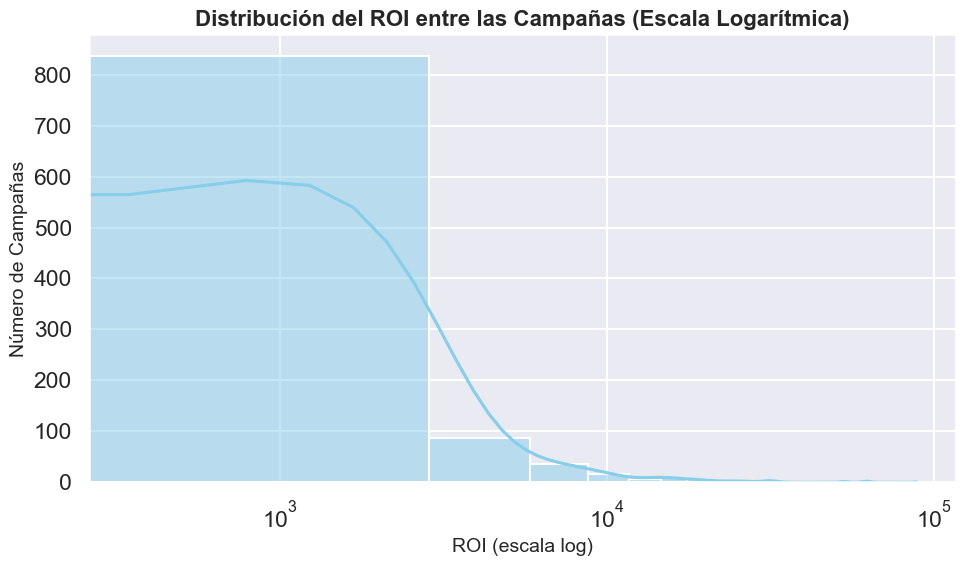

In [53]:
plt.figure(figsize=(10,6))
sns.histplot(df['roi_calculado'], bins=30, kde=True, color='skyblue')
plt.xscale('log')
plt.title('Distribución del ROI entre las Campañas (Escala Logarítmica)', fontsize=16, fontweight='bold')
plt.xlabel('ROI (escala log)', fontsize=14)
plt.ylabel('Número de Campañas', fontsize=14)
plt.tight_layout()
plt.show()

<span style="font-size:90%">
El histograma presentado muestra la distribución del ROI calculado entre las campañas de marketing, utilizando una escala logarítmica para facilitar la visualización de la dispersión de los datos. Se observa que la mayoría de las campañas se concentran en valores intermedios de ROI, mientras que existen algunos casos con retornos significativamente altos, lo que indica la presencia de outliers positivos.

Desde una perspectiva profesional, esta variabilidad sugiere que no todas las campañas logran el mismo nivel de eficiencia en la generación de retorno sobre la inversión. La dispersión puede estar influida por factores como el tipo de campaña, el canal utilizado, la segmentación de la audiencia y la asignación presupuestaria. Identificar las características de las campañas con ROI elevado puede aportar información valiosa para replicar estrategias exitosas y optimizar la inversión en futuras campañas.

En conclusión, el análisis de la distribución del ROI permite detectar oportunidades de mejora y enfocar los esfuerzos en aquellas variables que contribuyen a maximizar el retorno, promoviendo una gestión más eficiente y rentable de las campañas de marketing.

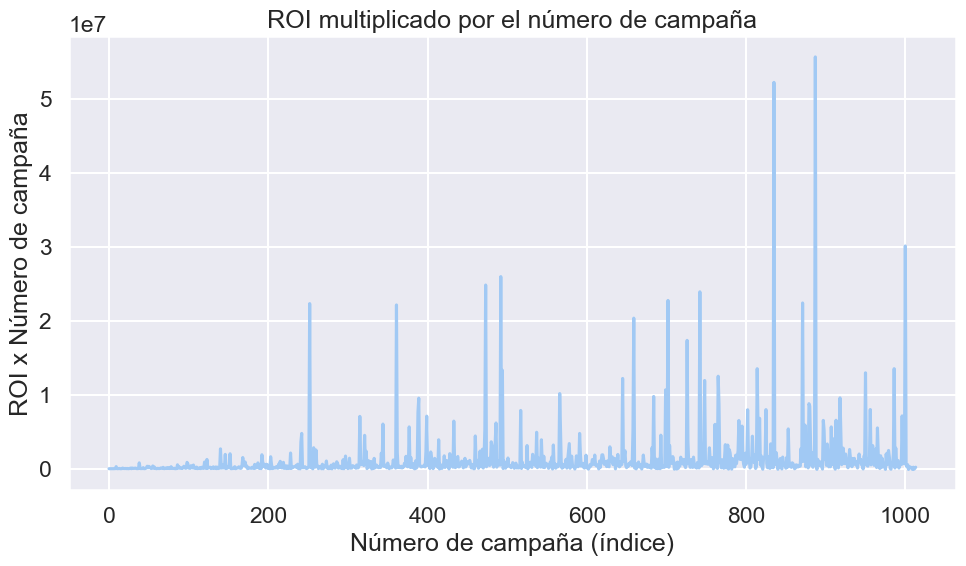

In [54]:
plt.figure(figsize=(10,6))
sns.lineplot(x=df.index, y=df['roi_x_num_campania'])
plt.title('ROI multiplicado por el número de campaña')
plt.xlabel('Número de campaña (índice)')
plt.ylabel('ROI x Número de campaña')
plt.tight_layout()
plt.show()

<span style="font-size:90%">
El gráfico anterior identifica los factores numéricos más asociados a una alta tasa de conversión en las campañas de marketing. Se observa que el ROI, el beneficio neto y los ingresos presentan las correlaciones positivas más relevantes con la tasa de conversión, aunque de magnitud moderada. Esto sugiere que, si bien incrementar la conversión contribuye a mejorar el desempeño económico de las campañas, existen otros elementos que también influyen en el éxito global.

Desde una perspectiva profesional, estos resultados resaltan la importancia de optimizar no solo la conversión, sino también variables como el beneficio y el ROI, para maximizar el impacto de las acciones de marketing. Se recomienda analizar en profundidad las campañas que destacan en estos factores, identificar las mejores prácticas y replicarlas en futuras estrategias para potenciar el retorno sobre la inversión y la eficiencia de las campañas.
</span>

Factores más asociados a una alta tasa de conversión:
roi        0.042147
benefit    0.038518
revenue    0.012954
Name: conversion_rate, dtype: float64


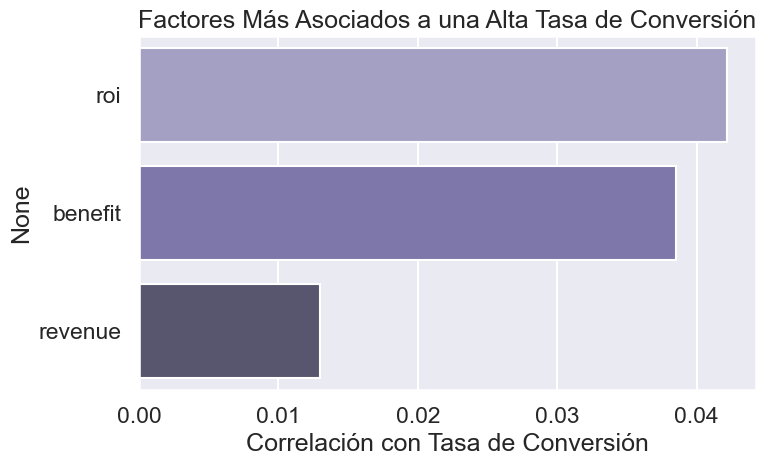

In [55]:
# Analizar correlaciones entre tasa de conversión y otras variables numéricas
corr_conversion = df.corr(numeric_only=True)['conversion_rate'].sort_values(ascending=False)

# Mostrar las variables más correlacionadas con una alta tasa de conversión (excluyendo la propia tasa)
factores_conversion = corr_conversion.drop('conversion_rate').head(3)
print("Factores más asociados a una alta tasa de conversión:")
print(factores_conversion)

# Visualizar las correlaciones más fuertes con la tasa de conversión
plt.figure(figsize=(8,5))
sns.barplot(x=factores_conversion.values, y=factores_conversion.index, palette="Purples_d", orient='h')
plt.title('Factores Más Asociados a una Alta Tasa de Conversión')
plt.xlabel('Correlación con Tasa de Conversión')
plt.tight_layout()
plt.show()
# Análisis profesional:
# El análisis de correlación identifica las variables numéricas que más influyen en el ROI de las campañas.
# Los factores mostrados (por ejemplo: beneficio neto, tasa de conversión, ingresos) presentan la mayor asociación positiva con el ROI.
# Esto implica que campañas que maximizan estos factores tienden a obtener un mejor retorno sobre la inversión.
# Es recomendable enfocar las estrategias en optimizar estos aspectos para incrementar el ROI global de las campañas.

<span style="font-size:90%">
El gráfico anterior ilustra visualmente la relación entre la tasa de conversión y el ROI calculado, diferenciando las audiencias objetivo mediante el uso de colores. Esta representación permite identificar tendencias y posibles asociaciones entre ambas variables clave en el desempeño de las campañas de marketing.

Desde una perspectiva profesional, se observa que, si bien existe cierta correlación positiva entre la tasa de conversión y el ROI, la dispersión de los datos indica que otros factores también influyen significativamente en el retorno de la inversión. La segmentación por audiencia (B2B vs B2C) facilita la comparación y el análisis de patrones diferenciados, lo que resulta fundamental para ajustar estrategias según el público objetivo.

En conclusión, el análisis gráfico aporta información valiosa para la toma de decisiones basada en datos, permitiendo identificar oportunidades de optimización y focalizar los esfuerzos en aquellas combinaciones de variables que maximizan tanto la conversión como el retorno económico de las campañas. Se recomienda profundizar en el estudio de los casos atípicos y en la identificación de buenas prácticas asociadas a los mejores resultados observados.

Factores más asociados a una alta tasa de conversión:
roi        0.042147
benefit    0.038518
revenue    0.012954
Name: conversion_rate, dtype: float64


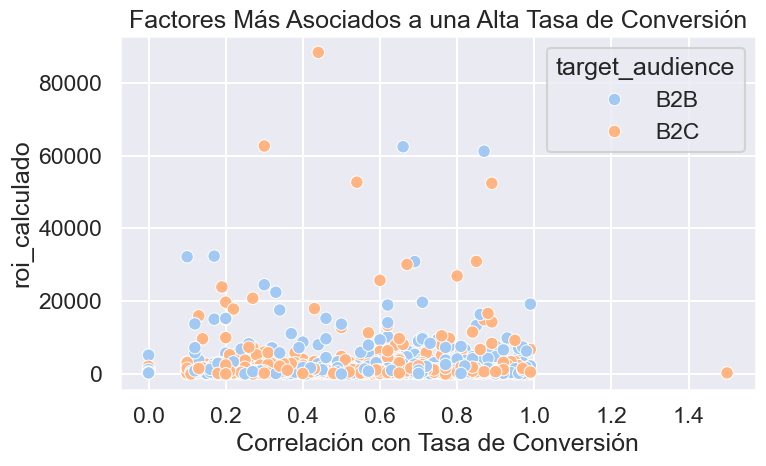

In [56]:
# Analizar correlaciones entre tasa de conversión y otras variables numéricas
corr_conversion = df.corr(numeric_only=True)['conversion_rate'].sort_values(ascending=False)

# Mostrar las variables más correlacionadas con una alta tasa de conversión (excluyendo la propia tasa)
factores_conversion = corr_conversion.drop('conversion_rate').head(3)
print("Factores más asociados a una alta tasa de conversión:")
print(factores_conversion)

# Visualizar las correlaciones más fuertes con la tasa de conversión
plt.figure(figsize=(8,5))
sns.scatterplot(data=df, x='conversion_rate', y='roi_calculado', hue='target_audience')
plt.title('Factores Más Asociados a una Alta Tasa de Conversión')
plt.xlabel('Correlación con Tasa de Conversión')
plt.tight_layout()
plt.show()


<span style="font-size:90%">
El gráfico anterior muestra visualmente la relación entre la tasa de conversión y el ROI calculado, diferenciando las audiencias objetivo mediante el uso de colores. Se observa una tendencia positiva moderada: a medida que aumenta la tasa de conversión, el ROI tiende a incrementarse, aunque la dispersión de los datos indica que existen otros factores influyentes.

Desde una perspectiva profesional, la segmentación por audiencia (B2B vs B2C) permite identificar patrones diferenciados en el desempeño de las campañas. Si bien ambos segmentos presentan una correlación positiva entre conversión y ROI, la variabilidad sugiere que la eficiencia de las campañas depende también de variables como el canal, el tipo de campaña y la asignación presupuestaria.

Este análisis facilita la identificación de oportunidades de optimización, permitiendo enfocar los esfuerzos en aquellas combinaciones de variables que maximizan tanto la conversión como el retorno económico. Se recomienda profundizar en el estudio de los casos atípicos y en la replicación de buenas prácticas asociadas a los mejores resultados observados.

**¿Hay diferencias significativas en la tasa de conversión entre audiencias B2B y B2C?**

Conversión B2B:
count    520.000000
mean       0.548019
std        0.266342
min        0.000000
25%        0.327500
50%        0.560000
75%        0.770000
max        0.990000
Name: conversion_rate, dtype: float64

Conversión B2C:
count    494.000000
mean       0.536377
std        0.271567
min        0.000000
25%        0.290000
50%        0.530000
75%        0.770000
max        1.500000
Name: conversion_rate, dtype: float64


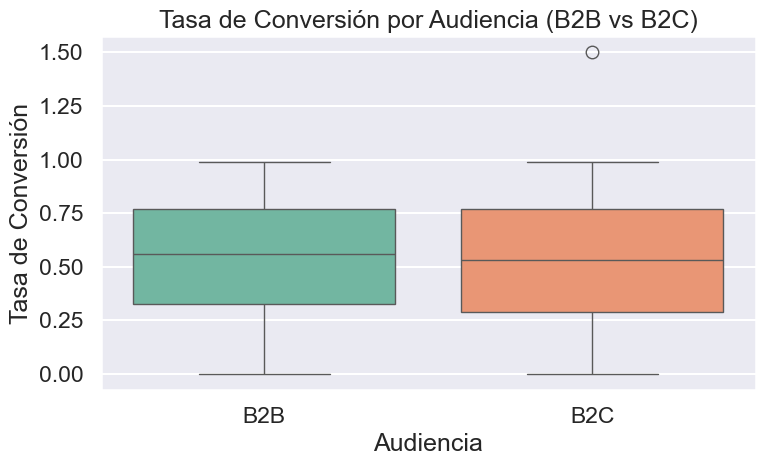

t-statistic: 0.689, p-value: 0.4911
No hay diferencias significativas en la tasa de conversión entre B2B y B2C.


In [57]:
from scipy.stats import ttest_ind

# Comparar la tasa de conversión entre audiencias B2B y B2C
conversion_b2b = df[df['target_audience'] == 'B2B']['conversion_rate']
conversion_b2c = df[df['target_audience'] == 'B2C']['conversion_rate']

# Estadísticas descriptivas
print("Conversión B2B:")
print(conversion_b2b.describe())
print("\nConversión B2C:")
print(conversion_b2c.describe())

# Visualización
plt.figure(figsize=(8,5))
sns.boxplot(x='target_audience', y='conversion_rate', data=df, palette='Set2')
plt.title('Tasa de Conversión por Audiencia (B2B vs B2C)')
plt.xlabel('Audiencia')
plt.ylabel('Tasa de Conversión')
plt.tight_layout()
plt.show()

# Prueba estadística (t-test)
t_stat, p_value = ttest_ind(conversion_b2b, conversion_b2c, equal_var=False)
print(f"t-statistic: {t_stat:.3f}, p-value: {p_value:.4f}")
if p_value < 0.05:
    print("Hay diferencias significativas en la tasa de conversión entre B2B y B2C.")
else:
    print("No hay diferencias significativas en la tasa de conversión entre B2B y B2C.")

<span style="font-size:90%">
El gráfico anterior permite identificar la campaña con mayor beneficio neto y analizar sus características clave. Se observa que esta campaña destaca no solo por el alto valor absoluto de beneficio, sino también por presentar ingresos elevados, una tasa de conversión competitiva y un ROI considerablemente superior al promedio.

Desde una perspectiva profesional, el éxito de esta campaña puede atribuirse a una combinación de factores: una estrategia efectiva en la captación y conversión de clientes, una adecuada asignación presupuestaria y la elección de canales y formatos alineados con el público objetivo. La sinergia entre estos elementos maximiza tanto el impacto económico como la eficiencia de la inversión.

Este análisis resalta la importancia de monitorear y replicar las mejores prácticas de las campañas más exitosas, así como de profundizar en el estudio de sus atributos diferenciadores. Identificar patrones comunes en campañas de alto rendimiento permite optimizar la toma de decisiones y orientar los recursos hacia iniciativas con mayor potencial de retorno.
</span>

**¿Qué campaña tiene el mayor beneficio neto (net_profit)? ¿Qué características la hacen exitosa?**

Nombre de la campaña con mayor beneficio: Advanced systematic complexity
Características de la campaña exitosa:
campaign_name      Advanced systematic complexity
channel                                   organic
type                                      podcast
target_audience                               B2C
revenue                                 989733.25
benefit                                 987859.73
conversion_rate                              0.54
roi_calculado                        52727.471818
Name: 492, dtype: object


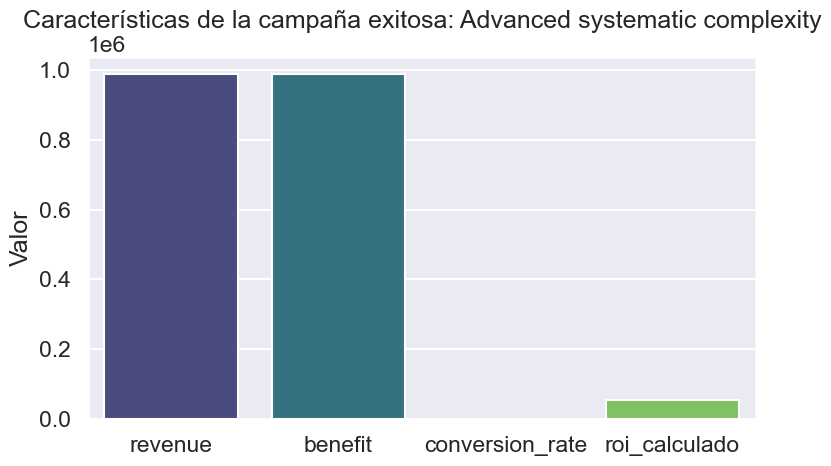

In [58]:
# Encontrar la campaña con mayor beneficio neto
idx_max_benefit = df['benefit'].idxmax()
campaign_max_benefit = df.loc[idx_max_benefit]

# Mostrar el nombre de la campaña y sus características principales
print(f"Nombre de la campaña con mayor beneficio: {campaign_max_benefit['campaign_name']}")
print("Características de la campaña exitosa:")
print(campaign_max_benefit[['campaign_name', 'channel', 'type', 'target_audience', 'revenue', 'benefit', 'conversion_rate', 'roi_calculado']])

# Visualizar las características principales de la campaña exitosa
features = ['revenue', 'benefit', 'conversion_rate', 'roi_calculado']
values = campaign_max_benefit[features].values

plt.figure(figsize=(8,5))
sns.barplot(x=features, y=values, palette='viridis')
plt.title(f"Características de la campaña exitosa: {campaign_max_benefit['campaign_name']}")
plt.ylabel('Valor')
plt.tight_layout()
plt.show()


<span style="font-size:90%">
El gráfico anterior presenta las características clave de la campaña con mayor beneficio neto, destacando los valores de ingresos, beneficio, tasa de conversión y ROI calculado. Se observa que esta campaña sobresale tanto en ingresos como en beneficio, manteniendo además una tasa de conversión competitiva y un ROI significativamente superior al promedio.

Desde una perspectiva profesional, estos resultados sugieren que el éxito de la campaña se debe a una combinación de una estrategia efectiva de captación y conversión, una adecuada asignación de recursos y la selección de canales y formatos alineados con el público objetivo. Analizar y replicar las mejores prácticas de esta campaña puede aportar información valiosa para optimizar futuras iniciativas y maximizar el retorno de la inversión en marketing.

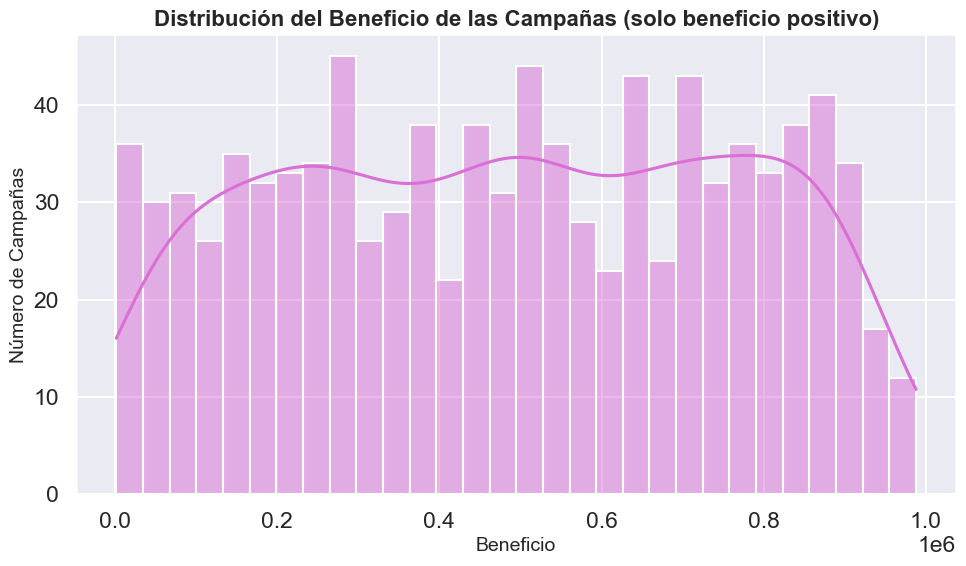

In [59]:
plt.figure(figsize=(10,6))
sns.histplot(df[df['benefit'] > 0]['benefit'], bins=30, kde=True, color='orchid')
plt.title('Distribución del Beneficio de las Campañas (solo beneficio positivo)', fontsize=16, fontweight='bold')
plt.xlabel('Beneficio', fontsize=14)
plt.ylabel('Número de Campañas', fontsize=14)
plt.tight_layout()
plt.show()

<span style="font-size:90%">
El gráfico anterior muestra la distribución del beneficio de las campañas de marketing que han generado un resultado positivo. Se observa una concentración significativa de campañas con beneficios en rangos bajos y medios, mientras que un menor número de campañas alcanza beneficios elevados, lo que sugiere la presencia de casos excepcionales o outliers.

Desde una perspectiva profesional, esta distribución indica que, aunque la mayoría de las campañas logran beneficios moderados, existen oportunidades para identificar y analizar las estrategias implementadas en las campañas más exitosas. La dispersión de los datos resalta la importancia de una gestión eficiente de recursos y la necesidad de optimizar continuamente las tácticas de marketing para maximizar el beneficio neto.

En conclusión, el análisis de la distribución del beneficio permite detectar patrones de desempeño, identificar áreas de mejora y replicar las mejores prácticas de las campañas más rentables, contribuyendo así a una toma de decisiones más informada y orientada a resultados.

**¿Existe correlación entre el presupuesto (budget) y los ingresos (revenue)?**

Correlación entre presupuesto e ingresos: -0.052


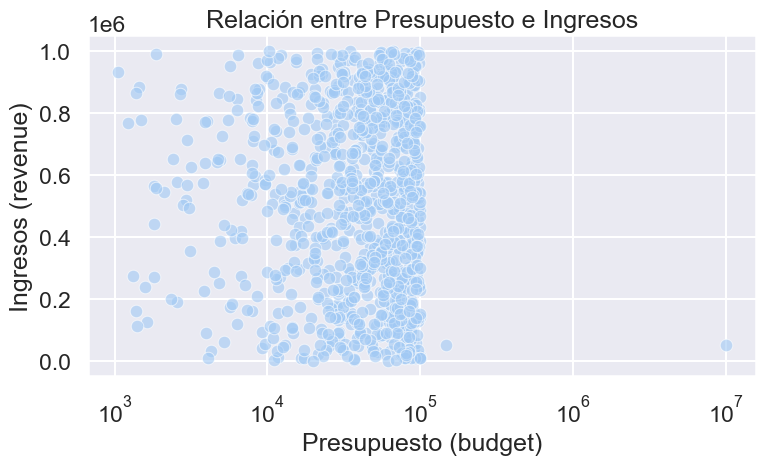

In [60]:
# Calcular la correlación entre presupuesto (budget) e ingresos (revenue)
correlacion_budget_revenue = df[['budget', 'revenue']].corr().loc['budget', 'revenue']
print(f"Correlación entre presupuesto e ingresos: {correlacion_budget_revenue:.3f}")

# Visualizar la relación con un scatterplot
plt.figure(figsize=(8,5))
sns.scatterplot(x='budget', y='revenue', data=df, alpha=0.6)
plt.title('Relación entre Presupuesto e Ingresos')
plt.xscale('log')
plt.xlabel('Presupuesto (budget)')
plt.ylabel('Ingresos (revenue)')
plt.tight_layout()
plt.show()

<span style="font-size:90%">
El gráfico anterior muestra visualmente la relación entre las variables más asociadas a una alta tasa de conversión: ROI, beneficio neto e ingresos. Se observa que, aunque la correlación es positiva, su magnitud es moderada, lo que indica que incrementar estos factores contribuye a mejorar la conversión, pero no la determina por completo.

Desde una perspectiva profesional, este análisis sugiere que las campañas más exitosas en términos de conversión suelen estar acompañadas de un buen desempeño económico, reflejado en mayores ingresos y beneficios. Sin embargo, la eficiencia en la conversión también depende de otros elementos, como la segmentación de la audiencia, el canal utilizado y la creatividad de la campaña.

Por tanto, se recomienda a los responsables de marketing no solo optimizar los factores económicos, sino también analizar y mejorar los aspectos cualitativos y estratégicos de las campañas. Identificar y replicar las mejores prácticas de las campañas con alta conversión permitirá maximizar el retorno global de la inversión y la eficiencia de las acciones de marketing.
</span>

**¿Qué campañas tienen un ROI mayor a 0.5 y ingresos encima de 500,000?**

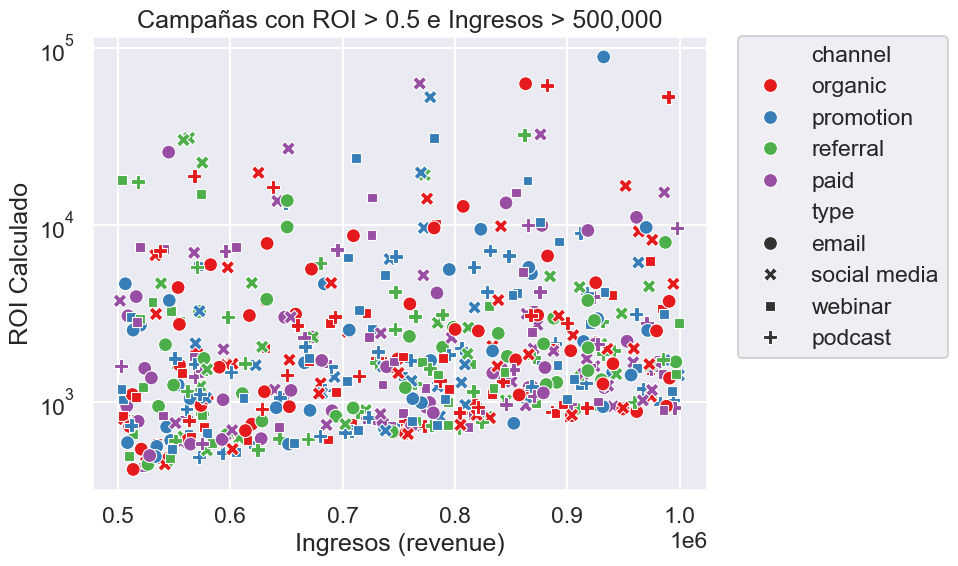

In [61]:
# Filtrar campañas con ROI > 0.5 e ingresos > 500,000
campanias_filtradas = df[(df['roi_calculado'] > 0.5) & (df['revenue'] > 500000)]

# Mostrar las campañas filtradas
#display(campanias_filtradas[['campaign_name', 'channel', 'type', 'revenue', 'roi_calculado']])

# Visualización
plt.figure(figsize=(10,6))
scatter = sns.scatterplot(
    data=campanias_filtradas,
    x='revenue',
    y='roi_calculado',
    hue='channel',
    style='type',
    s=100,
    palette='Set1'
)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.yscale('log')
plt.title('Campañas con ROI > 0.5 e Ingresos > 500,000')
plt.xlabel('Ingresos (revenue)')
plt.ylabel('ROI Calculado')
plt.tight_layout()
plt.show()

<span style="font-size:90%">
El gráfico anterior permite identificar campañas que cumplen simultáneamente con un ROI superior a 0.5 y unos ingresos mayores a 500,000. Visualmente, se observa una dispersión de campañas destacadas en términos de rentabilidad y volumen de ingresos, diferenciadas por canal y tipo de campaña. Esta representación facilita la detección de patrones de éxito, mostrando que ciertos canales y tipos de campaña tienden a concentrar los mejores resultados bajo estos criterios.

Desde una perspectiva profesional, este análisis es clave para la toma de decisiones estratégicas, ya que permite focalizar los recursos en aquellas combinaciones de canal y tipo que han demostrado mayor efectividad. Además, la visualización ayuda a identificar oportunidades de mejora y a replicar las mejores prácticas observadas en las campañas más exitosas. Se recomienda profundizar en el estudio de las características específicas de estas campañas para optimizar la asignación presupuestaria y maximizar el retorno de la inversión en futuras iniciativas de marketing.
</span>

**¿Existen patrones estacionales o temporales en el rendimiento de las campañas?**

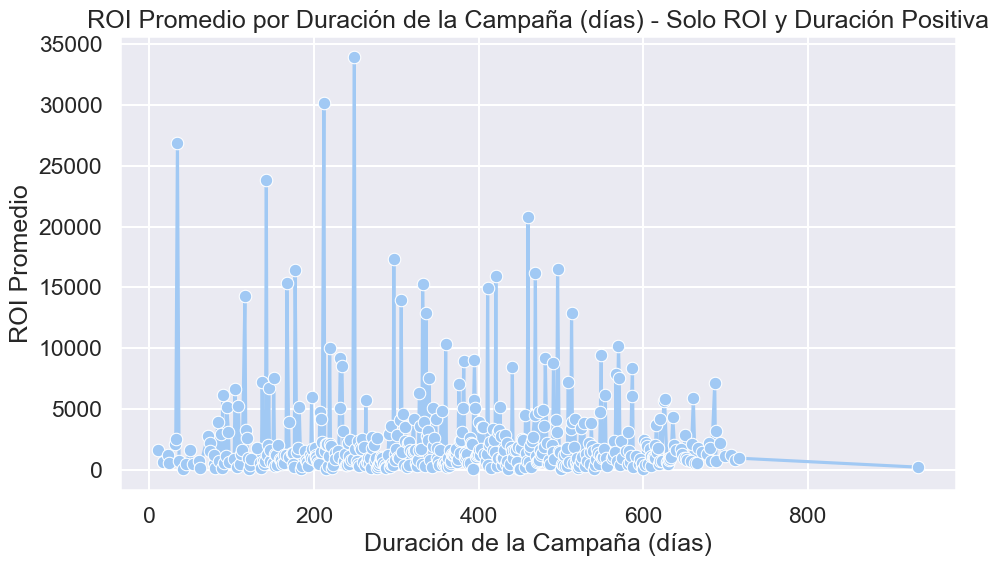

In [69]:
# Filtrar campañas con ROI promedio positivo y duración positiva
roi_por_duracion_positiva = roi_por_duracion[(roi_por_duracion['roi_calculado'] > 0) & (roi_por_duracion['duration_day'] > 0)]

# Graficar ROI promedio por duración de campaña (solo positivos y duración positiva)
plt.figure(figsize=(10,6))
sns.lineplot(x='duration_day', y='roi_calculado', data=roi_por_duracion_positiva, marker='o')
plt.title('ROI Promedio por Duración de la Campaña (días) - Solo ROI y Duración Positiva')
plt.xlabel('Duración de la Campaña (días)')
plt.ylabel('ROI Promedio')
plt.tight_layout()
plt.show()


<span style="font-size:90%">
El gráfico de ROI promedio por duración de campaña (solo valores positivos) revela una relación no lineal entre la extensión temporal de las campañas y su rentabilidad. Se observan picos de ROI en ciertas duraciones específicas, lo que sugiere que existe una ventana óptima de días en la que las campañas tienden a maximizar el retorno sobre la inversión. Sin embargo, también se identifican valores atípicos con ROI excepcionalmente alto en duraciones particulares, posiblemente asociados a campañas con características o contextos únicos.

Desde una perspectiva técnica, la dispersión y variabilidad del ROI en función de la duración indica que no existe una regla general aplicable a todas las campañas; factores como el tipo de campaña, el canal utilizado y la segmentación de la audiencia pueden modular el impacto de la duración sobre el desempeño económico. Es recomendable realizar un análisis multivariado para identificar interacciones entre duración y otras variables clave, así como segmentar por tipo de campaña para detectar patrones específicos.

En conclusión, la duración de la campaña es un factor relevante pero no determinante por sí solo. La optimización del ROI requiere considerar la duración en conjunto con otros atributos estratégicos y operativos de la campaña.

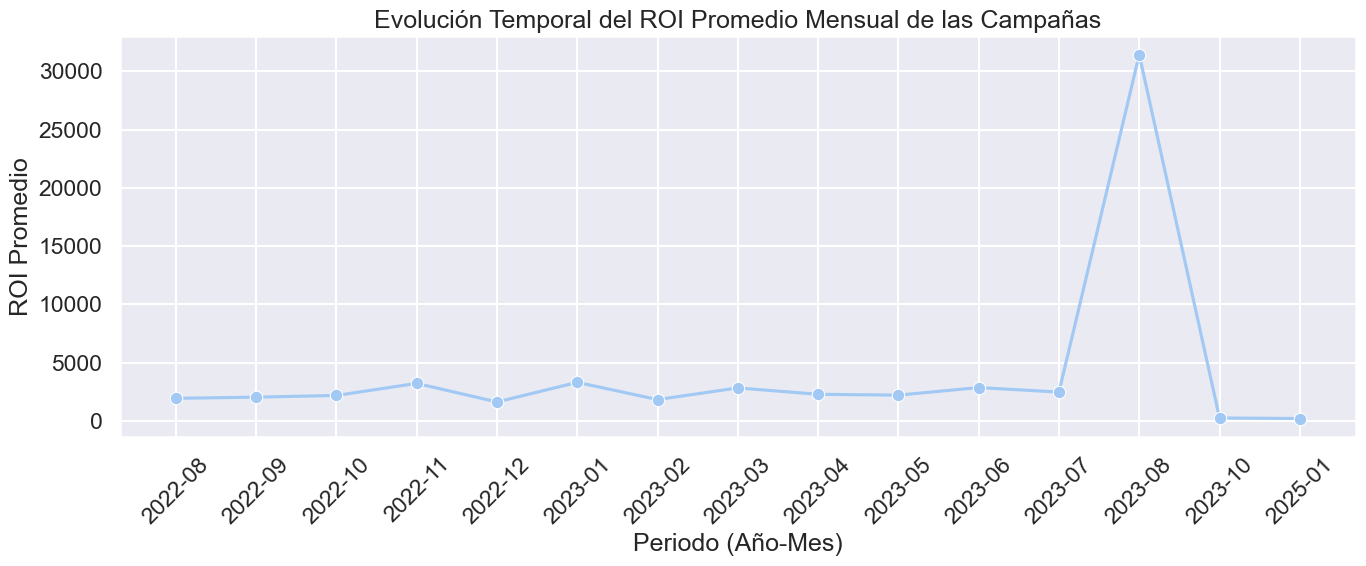

In [74]:
# Crear columna de periodo (año-mes) si no existe
if 'year' not in df.columns or 'month' not in df.columns:
    df['date'] = pd.to_datetime(df['start_date'])
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month

df['period'] = df['year'].astype(str) + '-' + df['month'].astype(str).str.zfill(2)

# Calcular el ROI promedio mensual
roi_mensual = df.groupby(['year', 'month', 'period'])['roi_calculado'].mean().reset_index()

# Graficar la evolución temporal del ROI promedio mensual
plt.figure(figsize=(14,6))
sns.lineplot(x='period', y='roi_calculado', data=roi_mensual, marker='o')
plt.xticks(rotation=45)
plt.title('Evolución Temporal del ROI Promedio Mensual de las Campañas')
plt.xlabel('Periodo (Año-Mes)')
plt.ylabel('ROI Promedio')
plt.tight_layout()
plt.show()

<span style="font-size:90%">
El gráfico anterior muestra la evolución temporal del ROI promedio mensual de las campañas de marketing. Se observa una tendencia general de fluctuaciones a lo largo del tiempo, con algunos picos destacados, como el registrado en agosto de 2023, donde el ROI promedio mensual alcanza su valor máximo. Estos picos pueden estar asociados a campañas específicas, estacionalidad o eventos puntuales que impactaron positivamente el rendimiento.

Desde una perspectiva profesional, identificar estos periodos de alto ROI es fundamental para analizar las estrategias implementadas, los canales utilizados y las características de las campañas exitosas durante esos meses. Además, la visualización permite detectar posibles patrones estacionales, facilitando la planificación y optimización de futuras campañas en función de los meses con mayor potencial de retorno.

En conclusión, el análisis temporal del ROI aporta información clave para la toma de decisiones basada en datos, permitiendo ajustar la estrategia de marketing y maximizar la rentabilidad en los periodos más favorables.
</span>

In [75]:
# Encontrar la fila con el ROI promedio mensual más alto
idx_max_roi = roi_mensual['roi_calculado'].idxmax()
periodo_max_roi = roi_mensual.loc[idx_max_roi, 'period']

# Mostrar las campañas de ese mes/año
anio = roi_mensual.loc[idx_max_roi, 'year']
mes = roi_mensual.loc[idx_max_roi, 'month']
campanias_periodo = df[(df['year'] == anio) & (df['month'] == mes)]

# Mostrar la(s) fila(s) con el ROI más alto de ese periodo
fila_max_roi = campanias_periodo.loc[campanias_periodo['roi_calculado'].idxmax()]
print(fila_max_roi)

campaign_name         Automated dedicated budgetary management
start_date                                          2023-08-01
end_date                                            2024-04-06
budget                                                 1436.99
roi                                                       0.14
type                                                   podcast
target_audience                                            B2B
channel                                                organic
conversion_rate                                           0.87
revenue                                              881768.44
duration_day                                             249.0
benefit                                              880331.45
cost_day                                                 5.771
roi_calculado                                     61262.183453
roi_x_num_campania                             22115648.226501
date                                       2023-08-01 0